In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import time
import chess
import chess.engine
import chess.svg
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output

import warnings
warnings.filterwarnings('ignore')

In [2]:
# def random_board(max_depth=200):
#     board = chess.Board()
#     depth = random.randrange(0, max_depth)

#     for _ in range(1):
#         all_moves = list(board.legal_moves)
#         random_move = random.choice(all_moves)
#         board.push(random_move)
#         if board.is_game_over():
#             break
        
#     return board

# board = random_board()
# board

In [3]:
# Define a neural network class for chess
class ChessNN(nn.Module):
    def __init__(self):
        super(ChessNN, self).__init__()
        
        # Define the layers of the neural network
        # Input layer: 64*12 units (one-hot encoding of the board for each of the 12 types of pieces)
        # Output layer: 64*64 units (outputting one value for each possible move)
        self.fc1 = nn.Linear(64 * 12, 256)  # Simple one-hot encoding of the board
        self.fc2 = nn.Linear(256, 64 * 64)  # Outputting one value for each possible move

    # Define the forward pass of the neural network
    def forward(self, x):
        # Apply the first fully connected layer followed by the ReLU activation function
        x = torch.relu(self.fc1(x))
        
        # Apply the second fully connected layer
        x = self.fc2(x)
        
        # Return the output
        return x


In [4]:
# Function to convert a chess board to a tensor representation
def board_to_tensor(board):
    # Initialize a tensor with zeros, representing the board
    board_tensor = np.zeros((12, 8, 8), dtype=np.float32)
    
    # Dictionary mapping piece symbols to indices in the tensor
    piece_to_idx = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5,
                    'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11}
    
    # Loop through each square on the chess board
    for i in range(64):
        # Get the piece at the current square
        piece = board.piece_at(i)
        
        # If there is a piece on the square
        if piece is not None:
            # Get the index of the piece in the tensor representation
            piece_idx = piece_to_idx.get(piece.symbol(), -1)
            
            # If the piece is recognized
            if piece_idx != -1:
                # Convert the square index to row and column
                row, col = divmod(i, 8)
                
                # Set the corresponding position in the tensor to 1 to indicate the presence of the piece
                board_tensor[piece_idx, row, col] = 1
                
    # Flatten the tensor and return
    return board_tensor.flatten()


In [5]:
# Function to select a move based on the given model and board state
def select_move(model, board, epsilon=0.2):
    # Get a list of legal moves for the current board state
    legal_moves = list(board.legal_moves)
    
    # If there are no legal moves available, return None and a score of 0
    if not legal_moves:
        return None, 0
    
    # Exploration: randomly choose a move with probability epsilon
    if random.random() < epsilon:
        # Choose a random move from the list of legal moves
        move = random.choice(legal_moves)
        
        # Return the randomly chosen move and a score of 0 (since it's random)
        return move, 0
    
    else:  # Exploitation: use the model to choose the best move
        # Convert the current board state into a tensor representation
        board_tensor = torch.FloatTensor([board_to_tensor(board)])
        
        # Disable gradient calculation during inference
        with torch.no_grad():
            # Get the model's predictions for the board state
            predictions = model(board_tensor).view(64, 64)
        
        # Calculate scores for each legal move based on the model's predictions
        move_scores = {move: predictions[move.from_square, move.to_square].item() for move in legal_moves}
        
        # Choose the move with the highest score
        best_move = max(move_scores, key=move_scores.get)
        
        # Return the best move and its corresponding score
        return best_move, move_scores[best_move]


In [6]:
# Basic method to give a reward based on what piece is captured
def get_move_reward(board, move):
    reward = 0
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        piece_value = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0.1}
        reward += piece_value.get(captured_piece.symbol().upper(), 0)
    return reward

def get_game_reward(result):
    # Defines reward based on the game result
    if result == "1-0":  # White wins
        return 1
    elif result == "0-1":  # Black wins
        return -1
    else:  # Draw
        return 0

In [7]:
def plot_training(losses, white_scores, black_scores, nn_move_counts, random_move_counts, fig, axs, window=10):
    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Smooth losses
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window) / window, mode='valid')
    else:
        smoothed_losses = losses  # Not enough data to smooth, use raw data

    # Plotting Training Losses
    axs[0].clear()
    axs[0].plot(smoothed_losses, label='Loss (smoothed)', color='purple')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting Move Counts by Type
    axs[1].clear()
    axs[1].plot(random_move_counts, label='Random Moves Count', color='orange')
    axs[1].plot(nn_move_counts, label='NN Moves Count', color='blue')
    axs[1].set_title('Move Counts by Type')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Average Count')
    axs[1].legend()

    # Plotting Scores by Player
    axs[2].clear()
    axs[2].plot(white_scores, label='White Score', color='lightblue')
    axs[2].plot(black_scores, label='Black Score', color='gray')
    axs[2].set_title('Score Tracking by Player')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Score')
    axs[2].legend()

    clear_output(wait=True)
    display(fig)

    return fig, axs


In [8]:
# Function to train the model using reinforcement learning
def train_model(model, optimizer, episodes=50, gamma=0.9):
    # Define the loss function
    loss_fn = torch.nn.MSELoss()
    
    # Initialize lists to store training data and statistics
    data = []
    losses, white_scores, black_scores, nn_move_counts, random_move_counts = [], [], [], [], []
    fig, axs = None, None

    # Loop through each episode
    for episode in range(episodes):
        # Initialize a new chess board
        board = chess.Board()
        
        # Initialize variables to track game statistics
        game_history = []
        episode_moves = [] 
        white_score = black_score = 0
        nn_count = random_count = 0

        # Play the game until it's over
        while not board.is_game_over():
            # Determine the exploration rate for this episode
            epsilon = max(0.1, 1 - episode / episodes)
            
            # Select a move using the epsilon-greedy strategy
            move, score = select_move(model, board, epsilon)
            
            # If no move is available, end the game
            if not move:
                break
            
            # Apply the selected move to the board
            board.push(move)
            
            # Record the game state and the chosen move
            game_state = board_to_tensor(board)
            game_history.append((game_state, move))

            # Record whether the move was made by the neural network or randomly
            move_type = "random" if score == 0 else "NN"
            if move_type == "random":
                random_count += 1
            else:
                nn_count += 1
            
            # Record move details
            move_detail = {
                "move": move.uci(),
                "type": "random" if score == 0 else "NN",
                "score": score if score != 0 else None
            }
            episode_moves.append(move_detail)

            # Calculate the reward for the move
            move_reward = get_move_reward(board, move)
            if board.turn == chess.BLACK:  # White just moved
                white_score += move_reward
            else:
                black_score += move_reward

        # Determine the result of the game
        result = board.result()
        
        # Calculate the final reward for the game
        reward = get_game_reward(result)
        total_loss = 0

       # Iterate over the game history in reverse order (from last to first)
        for state, move in reversed(game_history):
            # Convert the game state to a tensor suitable for processing by the model
            current_state_tensor = torch.FloatTensor([state])
            # Create a tensor for the reward associated with this state
            target_reward = torch.tensor([reward], dtype=torch.float32)
            # Use the model to predict the reward for the current state
            predicted_reward = model(current_state_tensor)
            # Compute the loss by comparing the predicted reward to the actual reward
            loss = loss_fn(predicted_reward, target_reward)
            # Reset gradients to avoid accumulation from previous iterations
            optimizer.zero_grad()
            # Perform backpropagation to calculate gradients
            loss.backward()
            # Update the model parameters based on the gradients
            optimizer.step()
            # Update the reward for the next iteration, applying a decay factor (gamma)
            reward = reward * gamma
            # Accumulate the loss for reporting or analysis purposes
            total_loss += loss.item()

        # Record statistics for this episode
        losses.append(total_loss)
        white_scores.append(white_score)
        black_scores.append(black_score)
        nn_move_counts.append(nn_count / max(1, len(game_history)))  # Normalize by total moves made
        random_move_counts.append(random_count / max(1, len(game_history)))  # Normalize by total moves made

        # Record data for this episode
        data.append({
            "Episode": episode + 1,
            "Loss": total_loss,
            "Result": result,
            "Winner": 'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw',
            "White Score": white_score,
            "Black Score": black_score,
            "NN Move Count": nn_count,
            "Random Move Count": random_count,
            "Moves": episode_moves
        })

        # Update plots real-time
        if episodes <= 100 or (episode % 10 == 0 or episode == episodes - 1):
            fig, axs = plot_training(losses, white_scores, black_scores, nn_move_counts, random_move_counts, fig, axs)

        # Print episode summary
        print(f"Episode {episode + 1}: Loss = {total_loss:.4f}, Result = {result}, Winner = {'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw'}, Moves Count = {len(episode_moves)}, Moves = {episode_moves}")

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data)
    return df


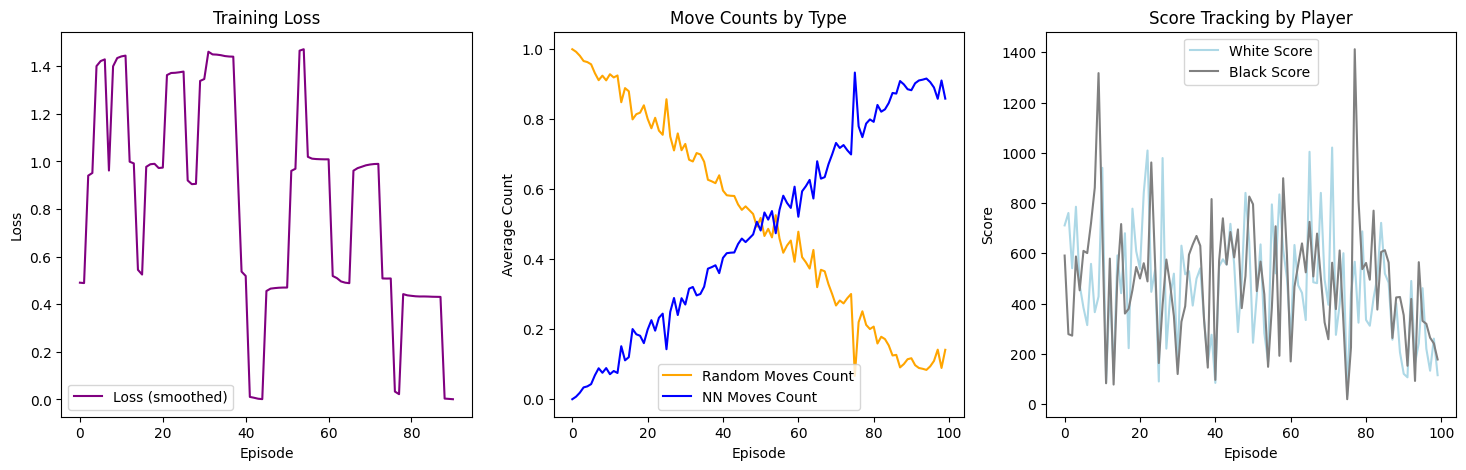

Episode 100: Loss = 0.0000, Result = 1/2-1/2, Winner = Draw, Moves Count = 85, Moves = [{'move': 'g1h3', 'type': 'NN', 'score': -5.7356199249625206e-05}, {'move': 'h7h6', 'type': 'NN', 'score': -3.6606070352718234e-05}, {'move': 'c2c3', 'type': 'NN', 'score': 3.1687086448073387e-06}, {'move': 'f7f6', 'type': 'NN', 'score': -1.0899413609877229e-05}, {'move': 'h3g5', 'type': 'NN', 'score': -1.0920717613771558e-05}, {'move': 'b7b5', 'type': 'NN', 'score': -4.9541311454959214e-05}, {'move': 'g5e6', 'type': 'NN', 'score': 2.5278452085331082e-05}, {'move': 'c8a6', 'type': 'random', 'score': None}, {'move': 'd1a4', 'type': 'NN', 'score': -1.0012881830334663e-05}, {'move': 'b5a4', 'type': 'NN', 'score': -9.672687156125903e-06}, {'move': 'e1d1', 'type': 'NN', 'score': -8.742827776586637e-05}, {'move': 'a6c4', 'type': 'NN', 'score': -5.1665629143826663e-05}, {'move': 'h2h3', 'type': 'NN', 'score': -5.383326788432896e-05}, {'move': 'c4a6', 'type': 'random', 'score': None}, {'move': 'h3h4', 'type'

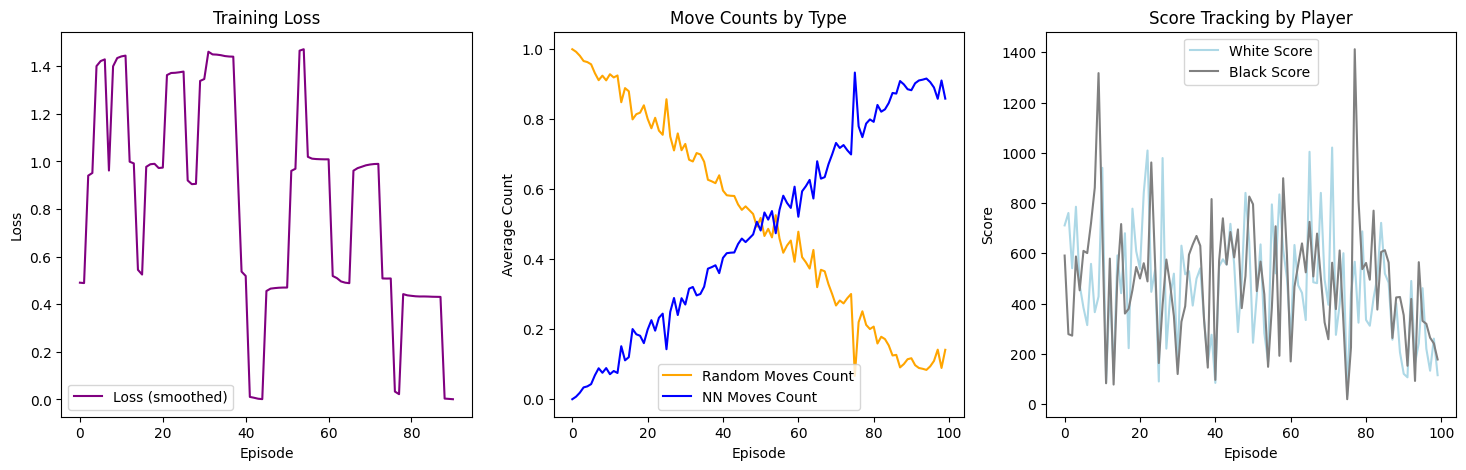

In [9]:
# Create an instance of the ChessNN model
model = ChessNN()

# Initialize the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model using the defined model, optimizer, and number of episodes
results = train_model(model, optimizer, episodes=100)


In [10]:
# print(results.head(5))
# print(results.tail(5))
print(results['Winner'].value_counts())
# with pd.option_context('display.max_colwidth', None):
#     print(results)

Winner
Draw     84
Black    10
White     6
Name: count, dtype: int64


In [11]:
torch.save(model.state_dict(), 'chess_model_draws.pth')
print("Model saved successfully.")


Model saved successfully.


In [12]:
model = ChessNN()
model.load_state_dict(torch.load('chess_model_draws.pth'))
model.eval()
print("Model loaded and set to evaluation mode.")


Model loaded and set to evaluation mode.


In [13]:
# Function to watch the model play a game of chess
def watch_model_play(model, ignore_draws=False, ignore_fivefold_repetition=False, ignore_seventyfive_moves=False):
    # Initialize a chess board
    board = chess.Board()
    move_count = 0
    
    # Continue playing until the game is over or a maximum number of moves is reached
    while True:
        if move_count > 250:
            print("Stopping due to too many moves")
            break
        
        # Check if the game is over
        if board.is_game_over():
            if board.is_checkmate():
                print("Checkmate.")
                break
            elif not ignore_draws:
                # Print out the reason for a draw if it can be claimed
                if board.can_claim_draw():
                    print("Draw can be claimed.")
                if board.is_stalemate():
                    print("Stalemate reached.")
                if board.is_insufficient_material():
                    print("Insufficient material for a checkmate.")
                if not ignore_seventyfive_moves and board.is_seventyfive_moves():
                    print("75-move rule reached.")
                if not ignore_fivefold_repetition and board.is_fivefold_repetition():
                    print("Fivefold repetition reached.")
                if board.is_variant_draw():
                    print("Draw by variant-specific rules.")
                break
        
        # Select a move using the model with epsilon=0 (exploitation)
        result = select_move(model, board, epsilon=0)
        
        # If no legal moves are available, end the game
        if result is None:
            print("No legal moves available")
            break
        
        # Make the selected move and update the board
        move, score = result
        board.push(move)
        
        # Clear the output and display the updated board
        clear_output(wait=True)
        display(HTML(chess.svg.board(board=board, lastmove=move, size=400)))
        print("Move:", move.uci())
        print("White to move" if board.turn else "Black to move")
        time.sleep(.1)  # Increase delay for visibility
        move_count += 1

    # Print the result of the game and the total move count
    print(f"\nGame result: {board.result()}")
    print("Move Count:", move_count)

# Testing the function with draw conditions ignored
watch_model_play(model, ignore_draws=True, ignore_fivefold_repetition=True, ignore_seventyfive_moves=True)


Move: c7b5
Black to move
Stopping due to too many moves

Game result: 1/2-1/2
Move Count: 251


This is working as a foundation, but the problem seems that the training and scoring for moves needs to be refactored. The AI is moving the pieces back and fourth without getting penalized, when it should be trying different moves. Maybe we put in a threshold when it gets above certain moves then it can start moving the same piece from the previous move. 

Issue is most games end in a draw.